Preprocessing: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.259.3762&rep=rep1&type=pdf

In [1]:
# All the libraries used
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import time
import random
import math

from scipy.ndimage import imread # Need to use scipy 1.1.0 to run imread
import scipy.ndimage
from scipy.misc import imresize
import scipy 
import seaborn as sns

## Loading files

In [2]:
path = "/Users/haley/Desktop/CMPE 255/Rentinal Classification/gaussian_diabetic_retino/gaussian_filtered_images/gaussian_filtered_images/"
level = ["Mild","Moderate","No_DR","Proliferate_DR","Severe"]
file_id = []
lstFilesDCM = []
for i in level:    
    for dirName, subdirList, fileList in os.walk(path+i):
        # Randomly pick k images from each level
        random_images = random.choices(fileList,k=190)
        for filename in random_images: 
            file_id.append(filename)
            lstFilesDCM.append(os.path.join(dirName,filename))   

In [3]:
len(file_id) # Total number of data points

950

In [4]:
target = pd.read_csv("gaussian_diabetic_retino/train.csv")
target.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [5]:
target['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [6]:
# To get the target values corresponding to given target csv file
y = []
for i in range(len(file_id)):
    code = file_id[i][:-4] # Slice to get rid of .png at the end of str
    label = target['diagnosis'][target['id_code'] == code]
    y.append(int(label))
y = np.array(y)

## Applying Gaussian filter with Laplacian

* Read about how Laplacian of Gaussian works here: https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm
* Using cv2 to apply this technique: 
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html

In [54]:
# 0. Read the data into Numpy
n = len(lstFilesDCM)
one = np.zeros((n,224,224))

# 0.5 Transfer All of the Data into array
print('===== READING DATA ========')
for file_index in range(n):
    one[file_index,:,:]   = imresize(imread(lstFilesDCM[file_index],mode='F',flatten=True),(224,224))
print('===== Done READING DATA ========')

===== READING DATA ========


/Users/haley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/Users/haley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


===== Done READING DATA ========


In [55]:
# LoG (Smooth) Function
data_array = []
for x in range(len(one)):
    s = 1.75
    temp = scipy.ndimage.filters.gaussian_filter(
        one[x,:,:],
        sigma = s
        )
    
    lap_kernel = np.array([
        [0,1,0],
        [1,-4,1],
        [0,1,0]
    ])

    result = cv2.filter2D(temp,-1,lap_kernel)
    data_array.append(result)
#     plt.axis('off')
#     plt.imshow(result,cmap='gray')
#     plt.savefig("LoG_images/"+ str(x) + '.png',bbox_inches='tight')
#     plt.show()
# -- end code --

In [ ]:
res = np.hstack((one[-1],result)) #stacking images side-by-side
plt.axis('off')
plt.imshow(res,cmap='gray')
plt.show()

In [56]:
data_array = np.array(data_array)
norm_one = (data_array - np.mean(data_array)) / math.sqrt(np.var(data_array))

## Histogram

* Applying Histograms Equalization: 
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html
* In-depth lecture on histogram analysis of digital image: https://web.cs.wpi.edu/~emmanuel/courses/cs545/S14/slides/lecture02.pdf

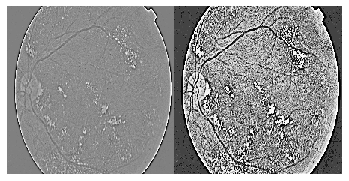

In [32]:
img = cv2.imread(lstFilesDCM[-1],0)
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
plt.axis('off')
plt.imshow(res,cmap='gray')
plt.show()

In [38]:
hist_data = []
for i in lstFilesDCM:
    img = cv2.imread(i,0)
    equ = cv2.equalizeHist(img)
    hist_data.append(equ)
    
hist_data = np.array(hist_data).flatten().reshape(n,-1)

In [29]:
hist_data[:2]

array([[103,  51,  76, ...,  39,  64,  64],
       [122,  41,  67, ..., 104,  41,  52]], dtype=uint8)

In [28]:
hist_data.shape

(950, 50176)

In [ ]:
# Using Histogram Equalization set
X_train, X_test, y_train, y_test = train_test_split(hist_data,y, test_size=0.3, random_state=42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

## Reshaping and splitting dataset

In [57]:
data_array = np.array(data_array).flatten().reshape(n,-1)

In [58]:
data_array.shape

(950, 50176)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(data_array,y, test_size=0.3, random_state=42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(665, 50176), (665,)
Test data and target sizes: 
(285, 50176), (285,)


## Data Preprocessing, Training and Testing

**PCA + SVM**

In [13]:
# Preprocessing with PCA
reduced_pca = PCA(n_components=0.8)
reduced_pca.fit(X_train)
X_train_reduced = reduced_pca.transform(X_train)
X_test_reduced = reduced_pca.transform(X_test)
print("Reduced Shape:", X_train_reduced.shape)

Reduced Shape: (665, 133)


In [14]:
# Number of PCA used to retained the percentage set for n_components
len(reduced_pca.explained_variance_ratio_)
#reduced_pca.explained_variance_ratio_

133

In [22]:
clf = svm.SVC(gamma='auto',class_weight='balanced')
starting_time = time.process_time()
clf.fit(X_train_reduced,y_train)
print("Data fitting takes", time.process_time() - starting_time, "seconds")
print("Testing Accuracy", clf.score(X_test_reduced, y_test))

Data fitting takes 0.23524000000000456 seconds
Testing Accuracy 0.47017543859649125


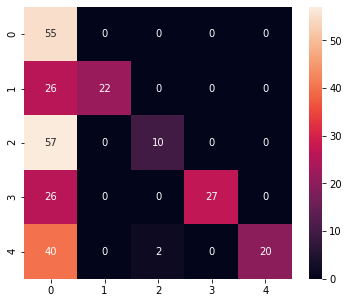

              precision    recall  f1-score   support

           0       0.27      1.00      0.42        55
           1       1.00      0.46      0.63        48
           2       0.83      0.15      0.25        67
           3       1.00      0.51      0.67        53
           4       1.00      0.32      0.49        62

    accuracy                           0.47       285
   macro avg       0.82      0.49      0.49       285
weighted avg       0.82      0.47      0.48       285



In [16]:
y_pred = clf.predict(X_test_reduced)
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
ax.set_ylim(5.0, 0)
plt.show()

print(classification_report(y_test,y_pred))

**KMeans + SVM**

In [60]:
# Preprocessing with KMeans
# Rule of thumb for picking K
k = math.sqrt(X_train.shape[0]/2)
kmnist_kmeans = KMeans(n_clusters=int(k), max_iter = 1000).fit(X_train)
X_train_cluster = kmnist_kmeans.transform(X_train)
X_test_cluster = kmnist_kmeans.transform(X_test)
print("Reduced Shape:", X_train_cluster.shape)

Reduced Shape: (665, 18)


In [61]:
kmean_svm = svm.SVC(gamma=0.001,class_weight='balanced')
starting_time = time.process_time()
kmean_svm.fit(X_train_cluster,y_train)
print("Data fitting takes", time.process_time() - starting_time, "seconds")
print("Testing Accuracy", kmean_svm.score(X_test_cluster, y_test))

Data fitting takes 0.19342799999992621 seconds
Testing Accuracy 0.5578947368421052


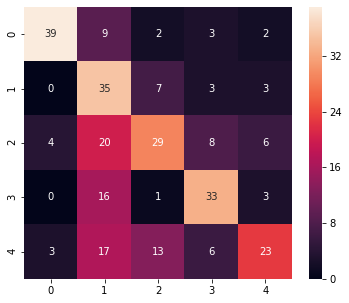

              precision    recall  f1-score   support

           0       0.85      0.71      0.77        55
           1       0.36      0.73      0.48        48
           2       0.56      0.43      0.49        67
           3       0.62      0.62      0.62        53
           4       0.62      0.37      0.46        62

    accuracy                           0.56       285
   macro avg       0.60      0.57      0.57       285
weighted avg       0.61      0.56      0.56       285



In [62]:
y_pred = kmean_svm.predict(X_test_cluster)
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
ax.set_ylim(5.0, 0)
plt.show()

print(classification_report(y_test,y_pred))